In [148]:
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
# from torch.nn.functional import relu
# from torch.nn.functional import tanh
# from torch.nn.functional import sigmoid
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d
from skimage.measure import block_reduce

## Reduce the data size by shrinking the image and allow symbolic dynamics to occur (based on doppler-effect).

### Load the data

In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
)
data_len = {'train': len(train_data), 'test': len(test_data)}

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
}

### Symbolic dynamics through iteration and non-linearity.
Through multiple iterations apply the doppler effect to the DCT of the images and apply convolution.  
Save the results in a dataframe for easy loading.

In [3]:
relu = np.vectorize(lambda x: np.maximum(0, x))
# sigmoid = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))
tanh = np.vectorize(np.tanh)

In [219]:
def apply_dynamics(sample, iters, f_act, vel, v_o, v_m, kernel, conv=False, pool=False):
    working_sample = np.copy(sample)

    for i in range(iters):
        v_s = vel(i, iters)
        # apply doppler effect to dct of sample
        s_dct = dct(dct(working_sample.T, norm='ortho').T, norm='ortho')  # decompose
        s_dct = ((v_m + v_o) / (v_m + v_s)) * s_dct  # doppler-effect
        s_dct = f_act(s_dct)  # activation function
        working_sample = idct(idct(s_dct.T, norm='ortho').T, norm='ortho')  # recompose

        # filter
        working_sample[working_sample < 0.01] = 0.0005

        if conv:
            working_sample = convolve2d(working_sample, kernel, mode='valid')  # convolution

        if pool and i % 4 == 1:
            working_sample = block_reduce(working_sample, (2, 2), np.mean, cval=0.5)

    return working_sample

###### Visualization
Changing `iters` determines the size of the output (if conv and/or pooling are on).

In [224]:
samples, labels = next(iter(loaders['train']))
sample = samples[0][0]

iters_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16, 20, 24, 30]

# vel_s is negative if moving towards observer
def v1(x, n):
    return -(x + 1) / (n / 3)
def v2(x, n):
    return x
def v3(x, n):
    return 1.5

f_v_list = list(product([relu, tanh], [v1, v2]))

v_o = 0  # positive if moving towards source
v_m = 5.022  # small tail to avoid division errors.
kernel = np.array([[0.25, 0.25],
                   [0.25, 0.25]])

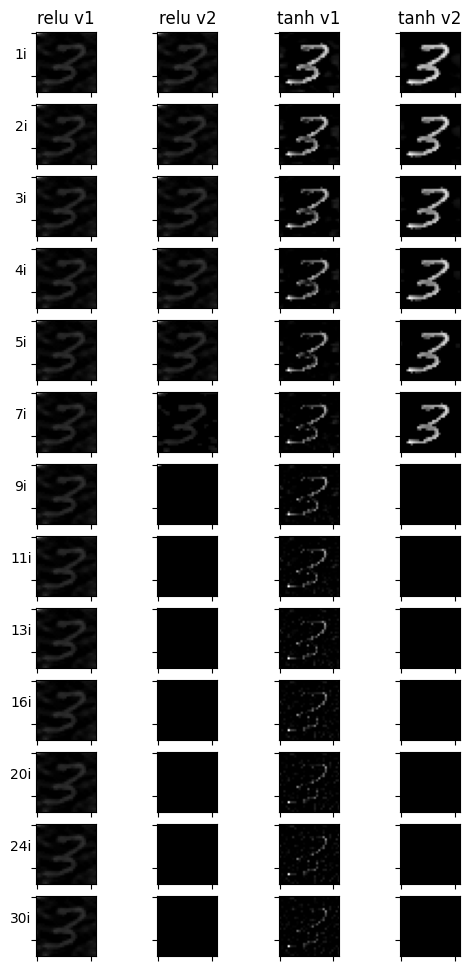

In [225]:
# No Conv, No Pool
fig, axs = plt.subplots(len(iters_list), len(f_v_list), figsize=(6, 12))
# fig.tight_layout(h_pad=0, w_pad=0)
axs[0, 0].set_title("relu v1")
axs[0, 1].set_title("relu v2")
axs[0, 2].set_title("tanh v1")
axs[0, 3].set_title("tanh v2")
for i, iters in enumerate(iters_list):
    axs[i, 0].set_ylabel(f"{iters}i", rotation=0)
for i, f_v in list(product(range(len(iters_list)), range(len(f_v_list)))):
    result = apply_dynamics(sample.numpy(), iters_list[i], f_v_list[f_v][0], f_v_list[f_v][1], v_o, v_m, kernel)
    axs[i, f_v].imshow(result, cmap='gray')
    axs[i, f_v].set_yticklabels([])
    axs[i, f_v].set_xticklabels([])

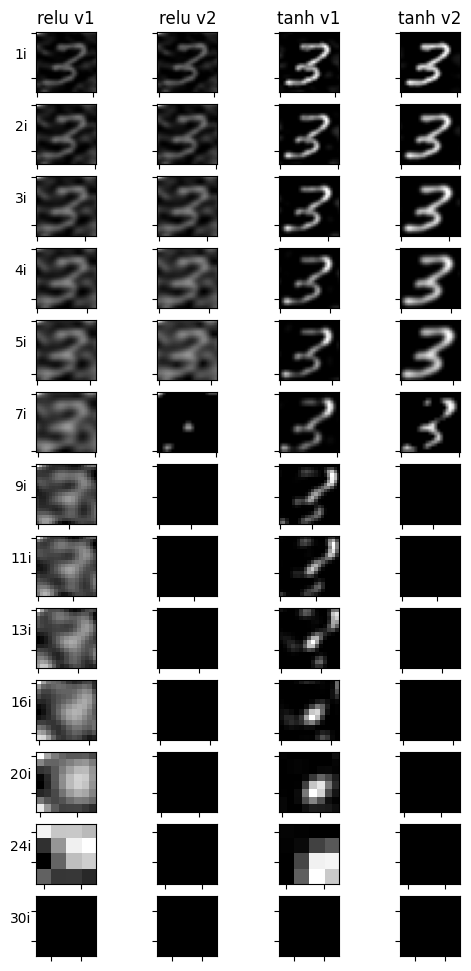

In [226]:
# Conv, No Pool
fig, axs = plt.subplots(len(iters_list), len(f_v_list), figsize=(6, 12))
# fig.tight_layout(h_pad=0, w_pad=0)
axs[0, 0].set_title("relu v1")
axs[0, 1].set_title("relu v2")
axs[0, 2].set_title("tanh v1")
axs[0, 3].set_title("tanh v2")
for i, iters in enumerate(iters_list):
    axs[i, 0].set_ylabel(f"{iters}i", rotation=0)
for i, f_v in list(product(range(len(iters_list)), range(len(f_v_list)))):
    result = apply_dynamics(sample.numpy(), iters_list[i], f_v_list[f_v][0], f_v_list[f_v][1], v_o, v_m, kernel, conv=True)
    axs[i, f_v].imshow(result, cmap='gray')
    axs[i, f_v].set_yticklabels([])
    axs[i, f_v].set_xticklabels([])

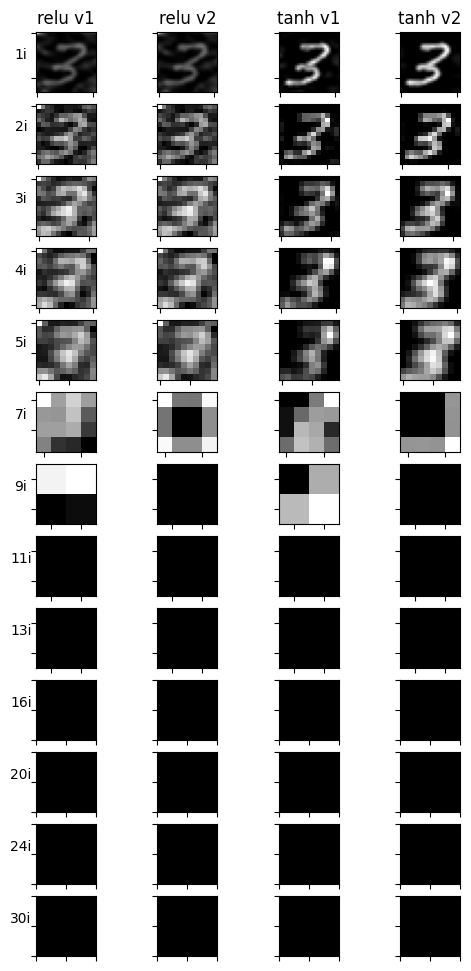

In [227]:
# Conv, Pool
fig, axs = plt.subplots(len(iters_list), len(f_v_list), figsize=(6, 12))
# fig.tight_layout(h_pad=0, w_pad=0)
axs[0, 0].set_title("relu v1")
axs[0, 1].set_title("relu v2")
axs[0, 2].set_title("tanh v1")
axs[0, 3].set_title("tanh v2")
for i, iters in enumerate(iters_list):
    axs[i, 0].set_ylabel(f"{iters}i", rotation=0)
for i, f_v in list(product(range(len(iters_list)), range(len(f_v_list)))):
    result = apply_dynamics(sample.numpy(), iters_list[i], f_v_list[f_v][0], f_v_list[f_v][1], v_o, v_m, kernel, conv=True, pool=True)
    axs[i, f_v].imshow(result, cmap='gray')
    axs[i, f_v].set_yticklabels([])
    axs[i, f_v].set_xticklabels([])

###### Convert all data
Changing `iters` determines the size of the output.

In [135]:
iters = 16
# vel_s is negative if moving towards observer
def v1(x, n):
    return -(x + 1) / (n / 3)
def v2(x, n):
    return x
def v3(x, n):
    return 1.5
f_act = tanh  # relu, tanh
v_o = 0  # positive if moving towards source
v_m = 5.022
kernel = np.array([[0.25, 0.25],
                   [0.25, 0.25]])

df_results = pd.DataFrame(columns=['data', 'label', 'train'])
for dset in ["train", "test"]:
    batch_size = 100
    batches = data_len[dset] / batch_size
    print(f"Begin reducing {dset}")
    for b, (images, labels) in enumerate(loaders[dset]):
        if b == batches:
            break
        for i in range(batch_size):
            result = apply_dynamics(images[i].numpy()[0], iters, f_act, v1, v_o, v_m, kernel, conv=True)
            result_str = np.array2string(result, separator=',')
            df_results = pd.concat([df_results, pd.DataFrame([[result_str, labels[i].numpy(), dset == "train"]], columns=df_results.columns)], ignore_index=True)

        if (b + 1) % 30 == 0:
            print('Reduced [{}/{}] {} batches for {} iterations'
                  .format(b + 1, batches, dset, iters))

print(df_results.shape)
df_results.to_csv(f'RedData/RedData_{iters}i.csv', index=False)

Begin reducing train


KeyboardInterrupt: 